In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import time

In [13]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  64


In [30]:
# Read and split the data
data = pd.read_csv("./mydata/court_appearance.csv")
data = data.sample(frac=1)
feature_name_list = list(data.columns)[1:-1]
data["fta_hist_times_appt_hist_inv"] = data.fta_hist * data.appt_hist_inv # add interaction term
feature_name_list += ["fta_hist_times_appt_hist_inv"]
total_offline_pop = 1000
offline_pop = data[:total_offline_pop]
online_pop = data[total_offline_pop:]

target_group_ids = np.where((offline_pop.targetgroup).to_numpy() == 1)[0]
nontarget_group_ids = np.where((offline_pop.targetgroup).to_numpy() == 0)[0]
target_group_size = target_group_ids.shape[0]
nontarget_group_size = nontarget_group_ids.shape[0]

In [5]:
### Some Helper Functions ###
def logit(p):
    """ Domain: (0, 1), Range: (-inf, inf). """
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    """ Domain: (-inf, inf), Range: (0, 1). """
    exp_p = np.exp(p)
    return exp_p / (1 + exp_p)

def whiten(ary):
    return (ary - np.mean(ary, axis=0)) / np.std(ary, axis=0)

def rmse(yhat, y):
    return np.sqrt(np.mean((yhat - y)**2))

In [7]:
##### DGP #####

## DGP Parameters ##
num_actions = 3
num_features = len(feature_name_list) + num_actions - 1

gamma_1 = 4 # 
gamma_2 = -0.75
transit_cost = 7.50

def appear_prob(person, action):
    return inv_logit(logit(person.control_true_appear_prob)
                     + gamma_1 * (action == 1)
                     + gamma_2 * (action == 2) * person.log_distance)

def rideshare_cost(person):
    return np.exp(person.log_distance + np.log(20)) * 10

offline_pop_true_probs = inv_logit(
    logit(offline_pop.control_true_appear_prob.to_numpy().reshape(-1, 1)) \
    + np.hstack([np.zeros((total_offline_pop, 1)), 
                 gamma_1 * np.ones((total_offline_pop, 1)),
                 gamma_2 * offline_pop.log_distance.to_numpy().reshape(-1, 1)]))

offline_pop_rideshare_costs = rideshare_cost(offline_pop)

offline_pop_costs = np.vstack([np.zeros(total_offline_pop), 
                               transit_cost * np.ones(total_offline_pop), 
                               offline_pop_rideshare_costs]).T


In [8]:
### Simulation Playground ###

## Find nearest neighbor ##
offline_pop_features = offline_pop[feature_name_list].to_numpy()
offline_pop_features_control = np.hstack([offline_pop_features, 
                                     np.hstack([np.zeros((total_offline_pop, 1)),
                                                np.zeros((total_offline_pop, 1))])])
offline_pop_features_a1 = np.hstack([offline_pop_features, 
                                     np.hstack([np.ones((total_offline_pop, 1)),
                                                np.zeros((total_offline_pop, 1))])])
offline_pop_features_a2 = np.hstack([offline_pop_features, 
                                     np.hstack([np.zeros((total_offline_pop, 1)),
                                                offline_pop.log_distance.to_numpy().reshape(-1, 1)])])

def get_offline_pop_MLE_reward_ests(model):
    """ Use model to compute MLE reward ests for the offline population. """
    # Manually compute probabilities for computational efficiency.
    coeffs = model.coef_
    intercept = model.intercept_
    offline_pop_control_logit = offline_pop_features_control[:, :-2] @ coeffs[:, :-2].T
    offline_pop_a1_logit = offline_pop_control_logit + coeffs[:, -2].reshape(-1, 1)
    offline_pop_a2_logit = offline_pop_control_logit + (offline_pop.log_distance.to_numpy() * coeffs[:, -1]).reshape(-1, 1)
    
    logits = np.hstack([offline_pop_control_logit,
                        offline_pop_a1_logit,
                        offline_pop_a2_logit]) + intercept
    MLE_reward_ests = inv_logit(logits)
    return MLE_reward_ests


def get_nn(person, model, offline_pred_appear_probs):
    """ Return row # of offline individual most 'similar' to person, 
        using a predictive model of appearance probability. """
    # compute person's comparison vector
    person_features = person[feature_name_list].to_numpy()
    person_pred_appear_prob_a1 = model.predict_proba(
        np.hstack([person_features, [[1, 0]]]))[0, 1]
    person_pred_appear_prob_a2 = model.predict_proba(
        np.hstack([person_features, [[0, person.log_distance.values[0]]]]))[0, 1]
    person_rideshare_cost = rideshare_cost(person)
    
    person_similarity_vector = np.hstack([person_pred_appear_prob_a1/transit_cost, 
                                          person_pred_appear_prob_a2/person_rideshare_cost]).reshape(-1, 1)

    # create comparison vector
    offline_pop_pred_appear_prob_a1 = offline_pred_appear_probs[:, 1]
    offline_pop_pred_appear_prob_a2 = offline_pred_appear_probs[:, 2]

    offline_similarity_vector = np.vstack([offline_pop_pred_appear_prob_a1/transit_cost, 
                                           offline_pop_pred_appear_prob_a2/offline_pop_rideshare_costs])
    
    l2_dists = np.linalg.norm(person_similarity_vector-offline_similarity_vector, ord=2, axis=0)
    return np.argmin(l2_dists)

## Test the nn function ##
# First train the model.
online_pop_sample_size = 10000
online_pop_sample = online_pop.sample(online_pop_sample_size)
random_actions = np.random.randint(3, size=online_pop_sample_size)
actions_onehot = np.zeros(shape=(online_pop_sample_size, 3))
actions_onehot[np.arange(online_pop_sample_size), random_actions] = 1

online_pop_features = online_pop_sample[feature_name_list].to_numpy()
online_pop_true_probs = appear_prob(online_pop_sample, random_actions).to_numpy()
sampled_rewards = np.random.binomial(1, online_pop_true_probs)
actions_onehot[:, 2] = actions_onehot[:, 2] * online_pop_sample.log_distance
online_pop_features_with_actions = np.hstack([online_pop_features, actions_onehot[:, 1:]])

model = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(online_pop_features_with_actions, sampled_rewards)
model_pred_appear_prob = model.predict_proba(online_pop_features_with_actions)[:, 1]
coeffs = model.coef_
intercept = model.intercept_
self_computed_probs = inv_logit(online_pop_features_with_actions @ coeffs.T + intercept)
print(rmse(self_computed_probs.reshape(-1), model_pred_appear_prob))
print(rmse(self_computed_probs.reshape(-1), online_pop_true_probs))

# Use the model to find the nearest neighbor for an offline individual (should return the same or similar individual).
person = offline_pop[100:101]
offline_pop_pred_appear_probs = get_offline_pop_MLE_reward_ests(model)
get_nn(person, model, offline_pop_pred_appear_probs)

6.752723919151766e-17
0.009777493942420216


100

In [15]:
### Computing Reward Ests from Data ###

def logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c):
    """ Use the inverse unnormalized covariance matrix to compute an exploration bonus. """
    control_bonuses = [(feature.reshape(1, -1) @ inv_unnorm_cov @ feature.reshape(-1, 1))[0]
                       for feature in offline_pop_features_control]
    a1_bonuses = [(feature.reshape(1, -1) @ inv_unnorm_cov @ feature.reshape(-1, 1))[0] 
                       for feature in offline_pop_features_a1]
    a2_bonuses = [(feature.reshape(1, -1) @ inv_unnorm_cov @ feature.reshape(-1, 1))[0] 
                       for feature in offline_pop_features_a2]
    # More efficient code
#     control_bonuses = np.array([xT_sigma_inv @ x.reshape(-1, 1)
#                        for xT_sigma_inv, x in zip(XT_sigma_inv, offline_pop_features_control)])
#     a1_bonuses = control_bonuses + inv_unnorm_cov[num_features-2, num_features-2]
#     a2_bonuses = control_bonuses + inv_unnorm_cov[num_features-1, num_features-1] * offline_pop.log_distance
    
    bonuses = np.sqrt(np.hstack([control_bonuses, a1_bonuses, a2_bonuses]))
    
    # rho_t = a + b * num_features/2 * np.log(1 + t/c)
    rho_t = 1 # We shrink rho_t to 1. 
    return bonuses * rho_t

def pointwise_opt_reward_ests(mle_rewards, inv_unnorm_cov, t, a=1, b=1, c=70): # default coeffs rough plug-in ests using theory
    return mle_rewards + logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c)

In [26]:
### Policy Optimizations ###

def compute_opt_policy_reward_max(reward_ests, budget):
    """ Compute policy which maximizes rewards. Takes as input reward estimates and budget constraint. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, 3), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, 3), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    utility_fn = faster_compile_param * exp_rew # for some reason multiplying by the param makes the problem compile faster...
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem

def compute_opt_policy_L1_budget_fairness(reward_ests, budget, lambda_g=0.004):
    """ Compute policy which maximizes rewards + L1 budget fairness. 
    Takes as input reward estimates, budget constraint, and scaling param. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, 3), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, 3), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    lambda_g_param = cp.Parameter(nonneg=True)
    target_group_spending = cp.sum(avg_per_person_spending[target_group_ids])/target_group_size
    nontarget_group_spending = cp.sum(avg_per_person_spending[nontarget_group_ids])/nontarget_group_size
    L1_budget_fairness = cp.abs(target_group_spending - average_expenditure) \
                + cp.abs(nontarget_group_spending - average_expenditure)
    
    
    utility_fn = faster_compile_param*exp_rew - lambda_g_param * L1_budget_fairness
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    lambda_g_param.value = lambda_g

    opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem

def compute_opt_policy_L1_budget_fairness_constrained(
    reward_ests, budget, 
    epsilon=0.316): # fairness value given lambda_g = 0.004 of optimization when solved with oracle parameters
    """ Compute policy which maximizes rewards subject to L1 budget fairness constraint."""
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, 3), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, 3), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    epsilon_param = cp.Parameter(nonneg=True)
    target_group_spending = cp.sum(avg_per_person_spending[target_group_ids])/target_group_size
    nontarget_group_spending = cp.sum(avg_per_person_spending[nontarget_group_ids])/nontarget_group_size
    L1_budget_fairness = cp.abs(target_group_spending - average_expenditure) \
                + cp.abs(nontarget_group_spending - average_expenditure)
    
    
    utility_fn = faster_compile_param*exp_rew 
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs + [L1_budget_fairness <= epsilon_param])
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    epsilon_param.value = epsilon

    opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem


def compute_opt_policy_budget_constraint_fairness(reward_ests, budget):
    """ Compute policy which maximizes rewards subject to group-wise budget constraints. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, 3), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, 3), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    target_group_spending = cp.sum(avg_per_person_spending[target_group_ids])/target_group_size
    nontarget_group_spending = cp.sum(avg_per_person_spending[nontarget_group_ids])/nontarget_group_size
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    
    utility_fn = faster_compile_param*exp_rew
    opt_problem = cp.Problem(cp.Maximize(utility_fn), 
                             basic_cstrs + [target_group_spending <= budget,
                                           nontarget_group_spending <= budget])
    opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem


def compute_opt_policy_weighted_rews(reward_ests, budget, 
                                     target_group_scaling_factor=2, 
                                     nontarget_group_scaling_factor=1):
    """ Compute policy which maximizes weighted expected rewards. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, 3), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, 3), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    target_group_scaling_factor_param = cp.Parameter(nonneg=True)
    nontarget_group_scaling_factor_param = cp.Parameter(nonneg=True)
    target_group_exp_rew = cp.sum(avg_per_person_rew[target_group_ids])/target_group_size
    nontarget_group_exp_rew = cp.sum(avg_per_person_rew[nontarget_group_ids])/nontarget_group_size
    
    utility_fn = target_group_scaling_factor_param * target_group_exp_rew * target_group_size / total_offline_pop \
               + nontarget_group_scaling_factor_param * nontarget_group_exp_rew * nontarget_group_size / total_offline_pop
    
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    target_group_scaling_factor_param.value= target_group_scaling_factor
    nontarget_group_scaling_factor_param.value = nontarget_group_scaling_factor
    
    opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem


def compute_opt_policy_L1_outcome_fairness(reward_ests, budget, lambda_g=0.5):
    """ Compute policy which maximizes expected reward + L1 outcome fairness. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, 3), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, 3), nonneg=True)
    avg_per_step_budget = cp.Parameter(nonneg=True)
    lambda_g_param = cp.Parameter(nonneg=True)
    
    avg_per_person_spending = cp.sum(cp.multiply(offline_pop_costs, policy_var), axis=1)
    average_expenditure = cp.sum(avg_per_person_spending)/total_offline_pop
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1,
               average_expenditure <= avg_per_step_budget]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    target_group_exp_rew = cp.sum(avg_per_person_rew[target_group_ids])/target_group_size
    nontarget_group_exp_rew = cp.sum(avg_per_person_rew[nontarget_group_ids])/nontarget_group_size
    L1_outcome_fairness = lambda_g_param * cp.abs(target_group_exp_rew - exp_rew) \
            + lambda_g_param * cp.abs(nontarget_group_exp_rew - exp_rew)
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    utility_fn = faster_compile_param*exp_rew - L1_outcome_fairness
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    avg_per_step_budget.value = budget
    lambda_g_param.value = lambda_g
    
    opt_problem.solve()
    return policy_var.value, utility_fn, reward_params, opt_problem

In [17]:
## Simulation ##

# Simulation parameters
per_person_budget = 5
warmup_batch_size = 10

def run_simulation(policy_optimizer, total_online_pop = 1000, adjust_budget=True):
    """ Run a simulation for an online pop of size 'total_online_pop'. Takes as input
    a particular policy optimizer. """
    np.random.seed() # set random seed for parallelization

    # Pretrain model with warmup batch. Make sure at least one male, one viet
    condition = True
    while condition:
        warmup_batch = online_pop.sample(warmup_batch_size)
        condition = (warmup_batch.is_male.to_numpy().sum() == 0) or (warmup_batch.targetgroup.to_numpy().sum() == 0)

        random_actions = np.random.randint(3, size=warmup_batch_size)
        actions_onehot = np.zeros(shape=(warmup_batch_size, 3))
        actions_onehot[np.arange(warmup_batch_size), random_actions] = 1
        actions_onehot[:, 2] *= warmup_batch.log_distance
        features = np.hstack([warmup_batch[feature_name_list], actions_onehot[:, 1:]])
        unnorm_cov = sum([np.outer(feature, feature) for feature in features])
        condition = (warmup_batch.is_male.to_numpy().sum() == 0) \
                    or (warmup_batch.targetgroup.to_numpy().sum() == 0) \
                    or np.linalg.matrix_rank(unnorm_cov) < num_features

    warmup_true_probs = appear_prob(warmup_batch, [1, 2, 0, 0]).to_numpy()
    sampled_rewards = np.random.binomial(1, warmup_true_probs)
    model = LogisticRegression(max_iter=int(1e4)).fit(features, sampled_rewards)

    inv_unnorm_cov = np.linalg.inv(sum([np.outer(feature, feature) for feature in features]))

    # Run simulation #
    est_utility_vals = []
    oracle_pihat_utility_vals = []
    oracle_pistar_utility_vals = []

    target_group_cum_expense, nontarget_group_cum_expense = 0, 0
    remaining_budget = per_person_budget * total_online_pop
    target_group_cum_expense_curve = []
    remaining_budget_curve = []
    avg_bonuses = [] 
    for t in tqdm(range(total_online_pop)):
        new_person = online_pop.sample(1)
        new_covariate = new_person[feature_name_list]

        # Compute the contextual policy and person-conditioned action distribution.
        mle_rewards = get_offline_pop_MLE_reward_ests(model)
        reward_ests = pointwise_opt_reward_ests(mle_rewards, inv_unnorm_cov, t)
        reward_bonuses = logistic_exploration_bonus(inv_unnorm_cov, t, a=1, b=1, c=70)
        if adjust_budget:
            remaining_avg_budget = max(remaining_budget/(total_online_pop - t), 0)
        else:
            remaining_avg_budget = per_person_budget
        with warnings.catch_warnings(): # catch 'not DPP' warnings
            warnings.simplefilter("ignore")
            computed_policy, utility_fn, reward_params, problem = policy_optimizer(reward_ests, remaining_avg_budget)
        nn_id = get_nn(new_person, model, mle_rewards)
        action_dist = computed_policy[nn_id, :]

        # Sample the action and reward
        try: # policy dist may not exactly sum to one (but will be very close).
            action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
        except:
            action_dist /= sum(action_dist) # correct for rounding errors
            print(action_dist)
            action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
        true_appearance_prob = appear_prob(new_person, action_taken)
        sampled_reward = np.random.binomial(1, true_appearance_prob)
        
        # Compute cost of action
        action_cost = 0
        if action_taken == 1:
            action_cost = transit_cost
        elif action_taken == 2:
            action_cost = rideshare_cost(new_person).values[0]

        # Update dataset and model
        action_onehot = np.zeros(3)
        action_onehot[action_taken] = 1
        action_onehot[2] *= new_covariate.log_distance
        new_feature = np.hstack([new_covariate.to_numpy(), action_onehot[1:].reshape(1, -1)]).T

        features = np.vstack([features, new_feature.T])
        sampled_rewards = np.concatenate([sampled_rewards, sampled_reward])
        model = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(features, sampled_rewards)

        # Update inverse unnorm cov matrix according to Sherman-Morrison formula.
        inv_unnorm_cov -= inv_unnorm_cov @ np.outer(new_feature, new_feature) @ inv_unnorm_cov / \
                            (1 + new_feature.T @ inv_unnorm_cov @ new_feature)
        
        # Record the estimated and true utility values of the learned and oracle policies.
        est_utility_vals.append(utility_fn.value)
        reward_params.value = offline_pop_true_probs
        oracle_pihat_utility_vals.append(utility_fn.value)        
        problem.solve()
        oracle_pistar_utility_vals.append(utility_fn.value)
        
        # Update remaining budget
        remaining_budget -= action_cost

        if new_person.targetgroup.values[0] == 1:
            target_group_cum_expense += action_cost
        elif new_person.targetgroup.values[0] == 0:
            nontarget_group_cum_expense += action_cost
        target_group_cum_expense_curve.append(target_group_cum_expense)
        remaining_budget_curve.append(remaining_budget)
    values = [est_utility_vals, oracle_pihat_utility_vals, oracle_pistar_utility_vals]
    return values, sampled_rewards, features, target_group_cum_expense_curve, remaining_budget_curve, mle_rewards # avg_bonuses

In [25]:
## Baseline e-greedy Simulation ##

## Define the rct policy params.
avg_action_costs_offline_pop = np.mean(offline_pop_costs, axis=0)
avg_unif_random_cost = np.mean(avg_action_costs_offline_pop)


def run_e_greedy(policy_optimizer, eps=0.1, total_online_pop = 1000, fixed_budget=False):
    """ Run the e-greedy algorithm for a specific optimization problem.  """
    np.random.seed() # set random seed for parallelization        

    # Pretrain model with warmup batch. Make sure at least one male, one viet
    condition = True
    while condition:
        warmup_batch = online_pop.sample(warmup_batch_size)
        condition = (warmup_batch.is_male.to_numpy().sum() == 0) or (warmup_batch.targetgroup.to_numpy().sum() == 0)

        random_actions = np.random.randint(3, size=warmup_batch_size)
        actions_onehot = np.zeros(shape=(warmup_batch_size, 3))
        actions_onehot[np.arange(warmup_batch_size), random_actions] = 1
        actions_onehot[:, 2] *= warmup_batch.log_distance
        features = np.hstack([warmup_batch[feature_name_list], actions_onehot[:, 1:]])
        unnorm_cov = sum([np.outer(feature, feature) for feature in features])
        condition = (warmup_batch.is_male.to_numpy().sum() == 0) \
                    or (warmup_batch.targetgroup.to_numpy().sum() == 0) \
                    or np.linalg.matrix_rank(unnorm_cov) < num_features

    warmup_true_probs = appear_prob(warmup_batch, [1, 2, 0, 0]).to_numpy()
    sampled_rewards = np.random.binomial(1, warmup_true_probs)
    model = LogisticRegression(max_iter=int(1e4)).fit(features, sampled_rewards)

    # Run simulation #
    est_utility_vals = []
    oracle_pihat_utility_vals = []
    oracle_pistar_utility_vals = []

    target_group_cum_expense, nontarget_group_cum_expense = 0, 0
    remaining_budget = per_person_budget * total_online_pop
    target_group_cum_expense_curve = []
    remaining_budget_curve = []
    avg_bonuses = [] 
    for t in tqdm(range(total_online_pop)):
        new_person = online_pop.sample(1)
        new_covariate = new_person[feature_name_list]

        # Compute the contextual policy and person-conditioned action distribution.
        mle_rewards = get_offline_pop_MLE_reward_ests(model)
        remaining_avg_budget = max(remaining_budget/(total_online_pop - t), 0)
        if fixed_budget:
            remaining_avg_budget = per_person_budget
        with warnings.catch_warnings(): # catch 'not DPP' warnings
            warnings.simplefilter("ignore")
            computed_policy, utility_fn, reward_params, problem = policy_optimizer(
                mle_rewards, remaining_avg_budget)
        nn_id = get_nn(new_person, model, mle_rewards)
        action_dist = computed_policy[nn_id, :]
        
        # Sample the action and reward
        if np.random.random() >= eps:
            # w/ prob 1-eps, take the greedy action.
            try:
                action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
            except:
                action_dist /= sum(action_dist) # correct for rounding errors
                print(action_dist)
                action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
        else:
            # w/ prob eps, take a random action.
            # Adjust the randomization probs so that expected spending is per_person_budget
            if np.random.random() <= per_person_budget / avg_unif_random_cost: 
                action_taken = np.random.randint(num_actions)
            else:
                action_taken = 0
            
            # Prevent spending over budget.
            if action_taken == 1 and transit_cost > remaining_budget:
                action_taken = 0
            elif action_taken == 2 and rideshare_cost(new_person).values[0] > remaining_budget:
                action_taken = 0
            
        true_appearance_prob = appear_prob(new_person, action_taken)
        sampled_reward = np.random.binomial(1, true_appearance_prob)
        
        # Compute cost of action
        action_cost = 0
        if action_taken == 1:
            action_cost = transit_cost
        elif action_taken == 2:
            action_cost = rideshare_cost(new_person).values[0]

        # Update dataset and model
        action_onehot = np.zeros(3)
        action_onehot[action_taken] = 1
        action_onehot[2] *= new_covariate.log_distance
        new_feature = np.hstack([new_covariate.to_numpy(), action_onehot[1:].reshape(1, -1)]).T

        features = np.vstack([features, new_feature.T])
        sampled_rewards = np.concatenate([sampled_rewards, sampled_reward])
        model = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(features, sampled_rewards)
        
        # Accumulate data
        est_utility_vals.append(utility_fn.value)
        reward_params.value = offline_pop_true_probs
        oracle_pihat_utility_vals.append(utility_fn.value)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _, utility_fn, _, _ = policy_optimizer(offline_pop_true_probs, remaining_avg_budget)
        oracle_pistar_utility_vals.append(utility_fn.value)

        
        # Update remaining budget
        remaining_budget -= action_cost
        

        if new_person.targetgroup.values[0] == 1:
            target_group_cum_expense += action_cost
        elif new_person.targetgroup.values[0] == 0:
            nontarget_group_cum_expense += action_cost
        target_group_cum_expense_curve.append(target_group_cum_expense)
        remaining_budget_curve.append(remaining_budget)
    values = [est_utility_vals, oracle_pihat_utility_vals, oracle_pistar_utility_vals]
    return values, sampled_rewards, features, target_group_cum_expense_curve, remaining_budget_curve, mle_rewards # avg_bonuses

In [20]:
### Plotting ###

# Compute average baseline appearance rates
avg_baseline_app_rate_target_group = np.mean(offline_pop['control_true_appear_prob'].to_numpy()[target_group_ids])
avg_baseline_app_rate_nontarget_group = np.mean(offline_pop['control_true_appear_prob'].to_numpy()[nontarget_group_ids])

def plotter(results):
    """ Plot all the results. This is to view the results for your own reference. This does not generate
    the figures in the paper. """
    online_pop_size = len(results[0][3])
    # Oracle Utilities
    oracle_pihat_utility_vals = np.array([result[0][1] for result in results])
    oracle_pistar_utility_vals = np.array([result[0][2] for result in results])
    normalized_pihat_utility_vals = oracle_pihat_utility_vals / oracle_pistar_utility_vals
    mean_oracle_pihat_utility_vals = np.mean(normalized_pihat_utility_vals, axis=0)
    ste_oracle_pihat_utility_vals = stats.sem(normalized_pihat_utility_vals, axis=0)
    plt.plot(mean_oracle_pihat_utility_vals)
    h1 = plt.fill_between(np.arange(mean_oracle_pihat_utility_vals.shape[0]), 
                     mean_oracle_pihat_utility_vals-ste_oracle_pihat_utility_vals, 
                     mean_oracle_pihat_utility_vals+ste_oracle_pihat_utility_vals,
                    alpha=0.5)
    h2 = plt.axhline(y=1, c="r")
    plt.title("Oracle Utility")
    plt.ylabel("Utility/Optimal Utility")
    plt.legend(handles=[h1, h2], labels=["pi_hat", "pi_star"])
    plt.ylim([0.8, 1.01])

    # Cumulative Spending
    plt.figure()
    plt.title("Cumulative Spending")
    target_group_cum_spending_curves = np.array([result[3] for result in results])
    remaining_budget_curves = np.array([result[4] for result in results])
    overall_cum_spending_curves = per_person_budget*online_pop_size - remaining_budget_curves
    nontarget_group_cum_spending_curves = overall_cum_spending_curves - target_group_cum_spending_curves
    
    mean_target_group_cum_spending_curve = np.mean(target_group_cum_spending_curves, axis=0)
    ste_target_group_cum_spending_curve = stats.sem(target_group_cum_spending_curves, axis=0)
    plt.plot(mean_target_group_cum_spending_curve)
    h1 = plt.fill_between(np.arange(mean_target_group_cum_spending_curve.shape[0]), 
                     mean_target_group_cum_spending_curve-ste_target_group_cum_spending_curve, 
                     mean_target_group_cum_spending_curve+ste_target_group_cum_spending_curve,
                    alpha=0.5)

    mean_nontarget_group_cum_spending_curve = np.mean(nontarget_group_cum_spending_curves, axis=0)
    ste_nontarget_group_cum_spending_curve = stats.sem(nontarget_group_cum_spending_curves, axis=0)
    plt.plot(mean_nontarget_group_cum_spending_curve)
    h2 = plt.fill_between(np.arange(mean_nontarget_group_cum_spending_curve.shape[0]), 
                     mean_nontarget_group_cum_spending_curve-ste_nontarget_group_cum_spending_curve, 
                     mean_nontarget_group_cum_spending_curve+ste_nontarget_group_cum_spending_curve,
                    alpha=0.5)
    
    mean_overall_cum_spending_curve = np.mean(overall_cum_spending_curves, axis=0)
    ste_overall_cum_spending_curve = stats.sem(overall_cum_spending_curves, axis=0)
    plt.plot(mean_overall_cum_spending_curve)
    h3 = plt.fill_between(np.arange(mean_overall_cum_spending_curve.shape[0]), 
                     mean_overall_cum_spending_curve-ste_overall_cum_spending_curve, 
                     mean_overall_cum_spending_curve+ste_overall_cum_spending_curve,
                    alpha=0.5)
    plt.legend(handles=[h1, h2, h3], 
               labels=["Target Group", "Nontarget Group", "Overall"])

    ## Cumulative Number Treated ##
    cum_num_target_group_curves = np.array([np.cumsum(result[2][warmup_batch_size:,0]) for result in results])
    cum_num_nontarget_group_curves = np.arange(cum_num_target_group_curves.shape[1]) - cum_num_target_group_curves

    ## Average per person spending between groups ##
    plt.figure()
    plt.title("Cumulative Average Spending Per Person")
    avg_per_person_spending_target_group = target_group_cum_spending_curves / cum_num_target_group_curves
    avg_per_person_spending_nontarget_group = nontarget_group_cum_spending_curves / cum_num_nontarget_group_curves
    
    mean_avg_per_person_spending_target_group = np.mean(avg_per_person_spending_target_group, axis=0)
    ste_avg_per_person_spending_target_group = stats.sem(avg_per_person_spending_target_group, axis=0)
    plt.plot(mean_avg_per_person_spending_target_group)
    h1 = plt.fill_between(np.arange(mean_avg_per_person_spending_target_group.shape[0]), 
                     mean_avg_per_person_spending_target_group-ste_avg_per_person_spending_target_group, 
                     mean_avg_per_person_spending_target_group+ste_avg_per_person_spending_target_group,
                    alpha=0.5)
    
    mean_avg_per_person_spending_nontarget_group = np.mean(avg_per_person_spending_nontarget_group, axis=0)
    ste_avg_per_person_spending_nontarget_group = stats.sem(avg_per_person_spending_nontarget_group, axis=0)
    plt.plot(mean_avg_per_person_spending_nontarget_group)
    h2 = plt.fill_between(np.arange(mean_avg_per_person_spending_nontarget_group.shape[0]), 
                     mean_avg_per_person_spending_nontarget_group-ste_avg_per_person_spending_nontarget_group, 
                     mean_avg_per_person_spending_nontarget_group+ste_avg_per_person_spending_nontarget_group,
                    alpha=0.5)
    plt.legend(handles=[h1, h2], labels=["Target Group", "Nontarget Group"])
    plt.ylim([0, 7.5])

    ## Average per person realized reward between groups ##
    target_group_cum_reward_curves = np.array([np.cumsum(result[1][warmup_batch_size:] \
                                     * result[2][warmup_batch_size:, 0]) for result in results])
    total_cum_reward_curves = np.array([np.cumsum(result[1][warmup_batch_size:]) for result in results])
    nontarget_group_cum_reward_curves = total_cum_reward_curves - target_group_cum_reward_curves
    plt.figure()
    plt.title("Cumulative Realized Reward")
    plt.plot(np.mean(target_group_cum_reward_curves, axis=0))
    plt.plot(np.mean(nontarget_group_cum_reward_curves, axis=0))
    plt.plot(np.mean(total_cum_reward_curves, axis=0))
    plt.legend(["Target Group", "Nontarget Group", "Overall"])

    plt.figure()
    plt.title("Cumulative Average Realized Reward Per Person")
    cum_avg_per_person_target_group_reward_curves = target_group_cum_reward_curves/cum_num_target_group_curves
    cum_avg_per_person_nontarget_group_reward_curves = nontarget_group_cum_reward_curves/cum_num_nontarget_group_curves
    
    mean_avg_per_person_reward_target_group = np.mean(cum_avg_per_person_target_group_reward_curves, axis=0)
    ste_avg_per_person_reward_target_group = stats.sem(cum_avg_per_person_target_group_reward_curves, axis=0)
    plt.plot(mean_avg_per_person_reward_target_group)
    h1 = plt.fill_between(np.arange(mean_avg_per_person_reward_target_group.shape[0]), 
                     mean_avg_per_person_reward_target_group-ste_avg_per_person_reward_target_group, 
                     mean_avg_per_person_reward_target_group+ste_avg_per_person_reward_target_group,
                    alpha=0.5)
    
    mean_avg_per_person_reward_nontarget_group = np.mean(cum_avg_per_person_nontarget_group_reward_curves, axis=0)
    ste_avg_per_person_reward_nontarget_group = stats.sem(cum_avg_per_person_nontarget_group_reward_curves, axis=0)
    plt.plot(mean_avg_per_person_reward_nontarget_group)
    h2 = plt.fill_between(np.arange(mean_avg_per_person_reward_nontarget_group.shape[0]), 
                     mean_avg_per_person_reward_nontarget_group-ste_avg_per_person_reward_nontarget_group, 
                     mean_avg_per_person_reward_nontarget_group+ste_avg_per_person_reward_nontarget_group,
                    alpha=0.5)
    h3 = plt.axhline(y=avg_baseline_app_rate_target_group, c="purple")
    h4 = plt.axhline(y=avg_baseline_app_rate_nontarget_group, c="r")

    plt.legend(handles=[h1, h2, h3, h4], labels=["Target Group", "Nontarget Group", 
                                         "Baseline (Target Group)", "Baseline (Nontarget Group)"])
    plt.ylim([0, 1])
    
    ## Average reward per dollar spent between groups ##
    cum_avg_rew_per_dollar_spent_target_group_curves = target_group_cum_reward_curves / target_group_cum_spending_curves
    cum_avg_rew_per_dollar_spent_nontarget_group_curves = nontarget_group_cum_reward_curves / nontarget_group_cum_spending_curves
    plt.figure()
    plt.title("(Cumulative) Average Realized Reward per Dollar Spent")
    
    mean_avg_rew_per_dollar_spent_target_group = np.mean(cum_avg_rew_per_dollar_spent_target_group_curves, axis=0)
    ste_avg_rew_per_dollar_spent_target_group = stats.sem(cum_avg_rew_per_dollar_spent_target_group_curves, axis=0)
    plt.plot(mean_avg_rew_per_dollar_spent_target_group)
    h1 = plt.fill_between(np.arange(mean_avg_rew_per_dollar_spent_target_group.shape[0]), 
                     mean_avg_rew_per_dollar_spent_target_group-ste_avg_rew_per_dollar_spent_target_group, 
                     mean_avg_rew_per_dollar_spent_target_group+ste_avg_rew_per_dollar_spent_target_group,
                    alpha=0.5)
    
    mean_avg_rew_per_dollar_spent_nontarget_group = np.mean(cum_avg_rew_per_dollar_spent_nontarget_group_curves, axis=0)
    ste_avg_rew_per_dollar_spent_nontarget_group = stats.sem(cum_avg_rew_per_dollar_spent_nontarget_group_curves, axis=0)
    plt.plot(mean_avg_rew_per_dollar_spent_nontarget_group)
    h2 = plt.fill_between(np.arange(mean_avg_rew_per_dollar_spent_nontarget_group.shape[0]), 
                     mean_avg_rew_per_dollar_spent_nontarget_group-ste_avg_rew_per_dollar_spent_nontarget_group, 
                     mean_avg_rew_per_dollar_spent_nontarget_group+ste_avg_rew_per_dollar_spent_nontarget_group,
                    alpha=0.5)
    plt.legend(handles=[h1, h2], labels=["Target Group", "Nontarget Group"])
    plt.ylim([0, 2])
    
    plt.figure()
    plt.title("(Average Reward Per Person - Baseline Rate) / Dollar Spent Per Person")
    
    te_per_dollar_spent_target_group_curves = (cum_avg_per_person_target_group_reward_curves 
                                               - avg_baseline_app_rate_target_group) / avg_per_person_spending_target_group
    te_per_dollar_spent_nontarget_group_curves = (cum_avg_per_person_nontarget_group_reward_curves 
                                                  - avg_baseline_app_rate_nontarget_group) / avg_per_person_spending_nontarget_group
    
    mean_te_per_dollar_spent_target_group = np.mean(te_per_dollar_spent_target_group_curves, axis=0)
    ste_te_per_dollar_spent_target_group = stats.sem(te_per_dollar_spent_target_group_curves, axis=0)
    plt.plot(mean_te_per_dollar_spent_target_group)
    h1 = plt.fill_between(np.arange(mean_te_per_dollar_spent_target_group.shape[0]), 
                     mean_te_per_dollar_spent_target_group-ste_te_per_dollar_spent_target_group, 
                     mean_te_per_dollar_spent_target_group+ste_te_per_dollar_spent_target_group,
                    alpha=0.5)
    
    mean_te_per_dollar_spent_nontarget_group = np.mean(te_per_dollar_spent_nontarget_group_curves, axis=0)
    ste_te_per_dollar_spent_nontarget_group = stats.sem(te_per_dollar_spent_nontarget_group_curves, axis=0)
    plt.plot(mean_te_per_dollar_spent_nontarget_group)
    h2 = plt.fill_between(np.arange(mean_te_per_dollar_spent_nontarget_group.shape[0]), 
                     mean_te_per_dollar_spent_nontarget_group-ste_te_per_dollar_spent_nontarget_group, 
                     mean_te_per_dollar_spent_nontarget_group+ste_te_per_dollar_spent_nontarget_group,
                    alpha=0.5)
    plt.legend(handles=[h1, h2], labels=["Target Group", "Nontarget Group"])
    plt.ylim([0, 0.1])

In [18]:
result = run_simulation(compute_opt_policy_reward_max)

100%|██████████| 1000/1000 [01:30<00:00, 11.09it/s]


In [ ]:
## Reward Max Simulation ##
# NOTE: if the parallelization doesn't work, try importing multiprocess as mp instead of multiprocessing.
pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_rew_max = pool.starmap_async(run_simulation, [(compute_opt_policy_reward_max, 1000) for _ in range(num_sims)]).get()
pool.close()

with warnings.catch_warnings(): # catch possible divide by zero budget errors.
    warnings.simplefilter("ignore")
    plotter(results_rew_max)

In [40]:
## L1 Budget Fairness Sim ##

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_L1_budget_fairness = pool.starmap_async(run_simulation, [(compute_opt_policy_L1_budget_fairness, 1000) 
                                                                 for _ in range(num_sims)]).get()
pool.close()  
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_L1_budget_fairness)

100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


In [107]:
## L1 Budget Fairness (Constrained v. w/ Oracle Constraint) Sim ##

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_L1_budget_fairness_oracle_constrained = pool.starmap_async(
    run_simulation, [(compute_opt_policy_L1_budget_fairness_constrained, 1000) for _ in range(num_sims)]).get()
pool.close()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_L1_budget_fairness_oracle_constrained)

100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]


In [ ]:
## L1 Budget Fairness (Constrained v. w/ Larger than Oracle Constraint) Sim ##
def results_L1_budget_fairness_constrained_large(reward_ests, budget):
    return results_L1_budget_fairness_constrained(reward_ests, budget, epsilon = 0.5)

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_L1_budget_fairness_oracle_constrained = pool.starmap_async(
    run_simulation, [(results_L1_budget_fairness_constrained_large, 1000) for _ in range(num_sims)]).get()
pool.close()

In [93]:
## Budget Constraint Fairness Sim ##

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_budget_constraint_fairness = pool.starmap_async(run_simulation, [(compute_opt_policy_budget_constraint_fairness, 1000) for _ in range(num_sims)]).get()
pool.close()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_budget_constraint_fairness)

100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


In [ ]:
## Weighted Rews Sim w/ default scaling. ##

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_weighted_rews = pool.starmap_async(run_simulation, [(compute_opt_policy_weighted_rews, 1000) 
                                                            for _ in range(num_sims)]).get()
pool.close()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_weighted_rews) 

 70%|███████   | 705/1000 [01:49<00:51,  5.76it/s]

In [55]:
# Weighted Rews Sim w/ big scaling factor.  #
def compute_opt_policy_weighted_rews_big(reward_ests, budget):
    return compute_opt_policy_weighted_rews(reward_ests, budget, target_group_scaling_factor=10)

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_weighted_rews_big = pool.starmap_async(
    run_simulation, 
    [(compute_opt_policy_weighted_rews_big, 1000) for _ in range(num_sims)]).get()
pool.close()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_weighted_rews_big)

 17%|█▋        | 172/1000 [00:30<02:36,  5.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 57%|█████▋    | 566/1000 [01:36<01:22,  5.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 98%|█████████▊| 981/1000 [02:47<00:03,  5.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_ms

In [67]:
## L1 Outcome Fairness Sim ##
def compute_opt_policy_L1_outcome_fairness_big_lambda(reward_ests, budget):
    return compute_opt_policy_L1_outcome_fairness(reward_ests, budget, lambda_g=10)

def compute_opt_policy_L1_outcome_fairness_small_lambda(reward_ests, budget):
    return compute_opt_policy_L1_outcome_fairness(reward_ests, budget, lambda_g=2)

In [70]:
# Big Lambda

pool = mp.Pool(mp.cpu_count())
num_sims = 25


results_L1_outcome_fairness_big_lambda = pool.starmap_async(
    run_simulation, [(compute_opt_policy_L1_outcome_fairness_big_lambda , 1000) for _ in range(num_sims)]).get()
pool.close()    

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_L1_outcome_fairness_big_lambda)

100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]


In [68]:
# Small Lambda

pool = mp.Pool(mp.cpu_count())
num_sims = 25


results_L1_outcome_fairness_small_lambda = pool.starmap_async(
    run_simulation, [(compute_opt_policy_L1_outcome_fairness_small_lambda , 1000) for _ in range(num_sims)]).get()
pool.close()    

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plotter(results_L1_outcome_fairness_small_lambda)

100%|██████████| 1000/1000 [05:31<00:00,  3.02it/s]


In [380]:
### Generate Synthesis Plot ###
# results indices for reference: (0, values), (1, rewards), (2, features), (3, target_group_cum_expense_curve), 
#          (4, remaining_budget_curve), (5, mle_rewards)
def get_synthesis_points_realized(results):
    """ From results return mean and ste of 
    (total average realized nontarget group $/person - target group $/person, 
     total average realized target group rew/person, 
     total average realized nontarget group rew/person,
     total average realized total rew/person). """
    
    # Compute population sizes
    online_pop_size = len(results[0][3])
    total_num_target_group_per_sim = np.array([
        np.sum(result[2][warmup_batch_size:, feature_name_list.index('targetgroup')]) for result in results])
    total_num_nontarget_group_per_sim = online_pop_size - total_num_target_group_per_sim
    
    # Compute amount spent per group
    total_budget = online_pop_size * per_person_budget
    total_spent_target_group_per_sim = np.array([result[3][-1] for result in results])
    total_spent_per_sim = np.array([total_budget - result[4][-1] for result in results])
    total_spent_nontarget_group_per_sim = total_spent_per_sim - total_spent_target_group_per_sim
        
    # Compute total reward per group
    total_target_group_reward_per_sim = np.array([np.sum(result[1][warmup_batch_size:] \
        * result[2][warmup_batch_size:, feature_name_list.index('targetgroup')]) for result in results])
    total_reward_per_sim = np.array([np.sum(result[1][warmup_batch_size:]) for result in results])
    total_nontarget_group_reward_per_sim = total_reward_per_sim - total_target_group_reward_per_sim
    
    spending_disparities_per_sim = total_spent_nontarget_group_per_sim / total_num_nontarget_group_per_sim \
        - total_spent_target_group_per_sim / total_num_target_group_per_sim
    target_group_rew_per_person_per_sim = total_target_group_reward_per_sim / total_num_target_group_per_sim
    nontarget_group_rew_per_person_per_sim = total_nontarget_group_reward_per_sim / total_num_nontarget_group_per_sim
    total_rew_per_person_per_sim = total_reward_per_sim / online_pop_size
    
    return ((np.mean(spending_disparities_per_sim), 2*stats.sem(spending_disparities_per_sim)), 
            (np.mean(target_group_rew_per_person_per_sim), 2*stats.sem(target_group_rew_per_person_per_sim)), 
            (np.mean(nontarget_group_rew_per_person_per_sim), 2*stats.sem(nontarget_group_rew_per_person_per_sim)),
            (np.mean(total_rew_per_person_per_sim), 2*stats.sem(total_rew_per_person_per_sim)))


def get_synthesis_points_final_expected(results, policy_optimizer):
    """ From results return mean and ste of 
    (final expected nontarget group $/person - target group $/person, 
     final expected target group rew/person, 
     final expected nontarget group rew/person,
     final expected total rew/person) under an average budget constraint. """
    final_mle_rewards = [result[5] for result in results]
    
    overall_exp_rews_per_person = []
    target_group_rews_per_person = []
    nontarget_group_rews_per_person = []
    exp_spending_diffs = []
    
    for mle_reward_est in final_mle_rewards:
        computed_policy, _, _, _ = policy_optimizer(mle_reward_est, per_person_budget)
        
        per_person_avg_spending = np.sum(np.multiply(offline_pop_costs, computed_policy), axis=1)
        exp_target_group_spending_per_person = np.mean(per_person_avg_spending[target_group_ids])
        exp_nontarget_group_spending_per_person = np.mean(per_person_avg_spending[nontarget_group_ids])
        
        per_person_avg_reward = np.sum(np.multiply(mle_reward_est, computed_policy), axis=1)
        exp_target_group_reward_per_person = np.mean(per_person_avg_reward[target_group_ids])
        exp_nontarget_group_reward_per_person = np.mean(per_person_avg_reward[nontarget_group_ids])
        exp_overall_reward_per_person = np.mean(per_person_avg_reward)
        
        exp_spending_diffs.append(exp_nontarget_group_spending_per_person - exp_target_group_spending_per_person)
        overall_exp_rews_per_person.append(exp_overall_reward_per_person)
        target_group_rews_per_person.append(exp_target_group_reward_per_person)
        nontarget_group_rews_per_person.append(exp_nontarget_group_reward_per_person)
    
    return ((np.mean(exp_spending_diffs), 2*stats.sem(exp_spending_diffs)),
            (np.mean(target_group_rews_per_person), 2*stats.sem(target_group_rews_per_person)),
            (np.mean(nontarget_group_rews_per_person), 2*stats.sem(nontarget_group_rews_per_person)),
            (np.mean(overall_exp_rews_per_person), 2*stats.sem(overall_exp_rews_per_person)))

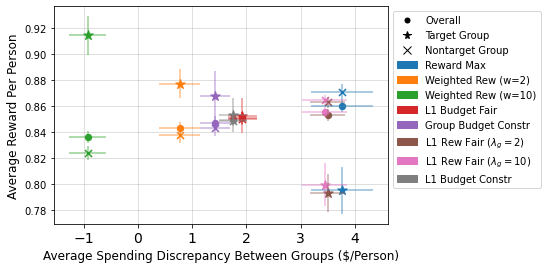

In [381]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### Realized Reward vs. Spending Synthesis Plot ###
fig, ax = plt.subplots()
color_patches = []
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
total_results = [results_rew_max, results_weighted_rews, results_weighted_rews_big, results_L1_budget_fairness, 
                 results_budget_constraint_fairness, results_L1_outcome_fairness_small_lambda, results_L1_outcome_fairness_big_lambda,
                 results_L1_budget_fairness_oracle_constrained]
color_index = 0
for results, name in zip(
        total_results,
        ["Reward Max", "Weighted Rew (w=2)", "Weighted Rew (w=10)", "L1 Budget Fair", 
         "Group Budget Constr", r"L1 Rew Fair ($\lambda_g=2$)", r"L1 Rew Fair ($\lambda_g=10$)",
         r"L1 Budget Constr"]):
    point = get_synthesis_points_realized(results)

    color = colors[color_index]
    # Overall
    ax.scatter(point[0][0], point[3][0], marker="o", color=color, s=40)
    plt.errorbar(point[0][0], point[3][0], xerr=point[0][1], yerr=point[3][1], color=color, alpha=0.5)

    # Target group
    ax.scatter(point[0][0], point[1][0], marker="*", color=color, s=100)
    plt.errorbar(point[0][0], point[1][0], xerr=point[0][1], yerr=point[1][1], color=color, alpha=0.5)

    # Nontarget group
    ax.scatter(point[0][0], point[2][0], marker="x", color=color, s=50)
    plt.errorbar(point[0][0], point[2][0], xerr=point[0][1], yerr=point[2][1], color=color, alpha=0.5)
    
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1

lgd = ax.legend(handles=[mlines.Line2D([], [], color='black', marker='o', linestyle='None', 
                                                 markersize=5, label='Overall'), 
                                   mlines.Line2D([], [], color='black', marker='*', linestyle='None', 
                                                 markersize=8, label='Target Group'), 
                                   mlines.Line2D([], [], color='black', marker='x', linestyle='None', 
                                                 markersize=8, label='Nontarget Group')] + color_patches,
          bbox_to_anchor=(1, 1))
plt.ylabel("Average Reward Per Person", fontsize=12)
plt.xlabel("Average Spending Discrepancy Between Groups ($/Person)", fontsize=12)
plt.xticks(fontsize=14)
plt.grid(alpha=0.5)
plt.savefig("scc_realized_comparison_plot.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [389]:
### Final Expected Reward v. Spending Synthesis Plot ###
points = []
for results, policy_optimizer in tqdm(zip(
        total_results,
        [compute_opt_policy_reward_max, compute_opt_policy_weighted_rews, compute_opt_policy_weighted_rews_big,
             compute_opt_policy_L1_budget_fairness, compute_opt_policy_budget_constraint_fairness, 
             compute_opt_policy_L1_outcome_fairness_small_lambda, 
             compute_opt_policy_L1_outcome_fairness_big_lambda, compute_opt_policy_L1_budget_fairness_constrained],
        )):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        points.append(get_synthesis_points_final_expected(results, policy_optimizer))
        
fig, ax = plt.subplots()
color_patches = []
color_index = 0
for point, name in zip(points,
        ["Reward Max", "Weighted Rew (w=2)", "Weighted Rew (w=10)", "L1 Budget Fair", 
         "Group Budget Constr", r"L1 Rew Fair ($\lambda_g=2$)", r"L1 Rew Fair ($\lambda_g=10$)",
         r"L1 Budget Constr"]):
    color = colors[color_index]
    # Overall
    ax.scatter(point[0][0], point[3][0], marker="o", color=color, s=40)
    plt.errorbar(point[0][0], point[3][0], xerr=point[0][1], yerr=point[3][1], color=color, alpha=0.5)

    # Target group
    ax.scatter(point[0][0], point[1][0], marker="*", color=color, s=100)
    plt.errorbar(point[0][0], point[1][0], xerr=point[0][1], yerr=point[1][1], color=color, alpha=0.5)

    # Nontarget group
    ax.scatter(point[0][0], point[2][0], marker="x", color=color, s=50)
    plt.errorbar(point[0][0], point[2][0], xerr=point[0][1], yerr=point[2][1], color=color, alpha=0.5)
    
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1

lgd = ax.legend(handles= color_patches + [mlines.Line2D([], [], color='black', marker='o', linestyle='None', 
                                                 markersize=5, label='Overall'), 
                                   mlines.Line2D([], [], color='black', marker='*', linestyle='None', 
                                                 markersize=8, label='Target Group'), 
                                   mlines.Line2D([], [], color='black', marker='x', linestyle='None', 
                                               markersize=8, label='Nontarget Group')],
          bbox_to_anchor=(0, 1.2, 0.9, 0.2), loc=9, ncol=3)
plt.ylabel("Expected Reward Per Person", fontsize=14)
plt.xlabel("Expected Spending Discrepancy \n Between Groups ($/Person)", fontsize=14)
plt.xlim([-3.3, 5.5])
plt.grid(alpha=0.5)
plt.savefig("scc_expected_comparison_plot.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

8it [00:39,  4.93s/it]


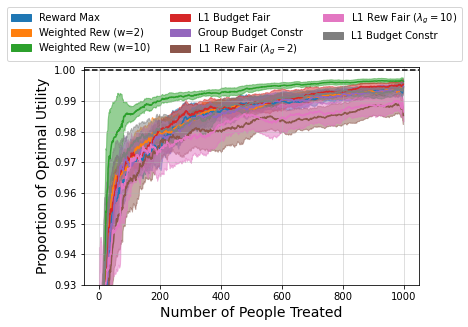

In [405]:
### Comparison Plots for Convergence ###
fig, ax = plt.subplots()
color_patches = []
color_index = 0
for results, name in zip(
        total_results,
        ["Reward Max", "Weighted Rew (w=2)", "Weighted Rew (w=10)", "L1 Budget Fair", 
         "Group Budget Constr", r"L1 Rew Fair ($\lambda_g=2$)", r"L1 Rew Fair ($\lambda_g=10$)",
         r"L1 Budget Constr"]):
    point = get_synthesis_points_realized(results)
    color = colors[color_index]

    # Oracle Utilities
    oracle_pihat_utility_vals = np.array([result[0][1] for result in results])
    oracle_pistar_utility_vals = np.array([result[0][2] for result in results])
    if name == r"L1 Rew Fair ($\lambda_g=2$)":
        oracle_pihat_utility_vals += 4
        oracle_pistar_utility_vals += 4
    if name == r"L1 Rew Fair ($\lambda_g=10$)":
        oracle_pihat_utility_vals += 2*10
        oracle_pistar_utility_vals += 2*10
    normalized_pihat_utility_vals = oracle_pihat_utility_vals / oracle_pistar_utility_vals
    mean_oracle_pihat_utility_vals = np.mean(normalized_pihat_utility_vals, axis=0)
    ste_oracle_pihat_utility_vals = stats.sem(normalized_pihat_utility_vals, axis=0)
    plt.plot(mean_oracle_pihat_utility_vals, color=color)
    h1 = plt.fill_between(np.arange(mean_oracle_pihat_utility_vals.shape[0]), 
                     mean_oracle_pihat_utility_vals-2*ste_oracle_pihat_utility_vals, 
                     mean_oracle_pihat_utility_vals+2*ste_oracle_pihat_utility_vals,
                    alpha=0.5,
                         color=color)
    color_patches.append(mpatches.Patch(color=color, label=name))
    color_index += 1

lgd = ax.legend(handles=color_patches,
          bbox_to_anchor=(0, 1.2, 0.9, 0.1), loc=9, ncol=3)
plt.axhline(y=1, linestyle="--", c="black")
plt.ylabel("Proportion of Optimal Utility", fontsize=14)
plt.ylim([0.93, 1.001])
plt.xlabel("Number of People Treated", fontsize=14)
plt.grid(alpha=0.5)
plt.savefig("scc_convergence_comparison.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [24]:
## Reward Max e-greedy Simulation ##
# Split up runs into two groups for computational reasons. For reference, we ran on a machine with 64 CPU's.

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_e_greedy_rew_max = pool.starmap_async(run_e_greedy, [(compute_opt_policy_reward_max, 0.1, 1000, False) 
                                                             for _ in range(num_sims)]).get()
pool.close()

pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_e_greedy_rew_max_2 = pool.starmap_async(run_e_greedy, [(compute_opt_policy_reward_max, 0.1, 1000, False) 
                                                               for _ in range(num_sims)]).get()
pool.close()

results_e_greedy = results_e_greedy_rew_max + results_e_greedy_rew_max_2

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

Process ForkPoolWorker-23:
Process ForkPoolWorker-8:
Process ForkPoolWorker-16:
Process ForkPoolWorker-14:
Process ForkPoolWorker-20:
Process ForkPoolWorker-10:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Process ForkPoolWorker-4:
Process ForkPoolWorker-47:
Process ForkPoolWorker-17:
Process ForkPoolWorker-57:
Process ForkPoolWorker-18:
Process ForkPoolWorker-48:
Process ForkPoolWorker-55:
Process ForkPoolWorker-62:
Process ForkPoolWorker-42:
Process ForkPoolWorker-46:
Process ForkPoolWorker-49:
Process ForkPoolWorker-59:
Process ForkPoolWorker-44:
Process ForkPoolWorker-3:
Process ForkPoolWorker-63:
Process ForkPoolWorker-41:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-58:
Process ForkPoolWorker-43:
Process ForkPoolWorker-51:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-1:
Process ForkPoolWorker-60:
Process ForkPoolWorker-9:
Proces

In [ ]:
# Collect additional samples for solving reward max using optimism.
pool = mp.Pool(mp.cpu_count())
num_sims = 25

results_rew_max_2 = pool.starmap_async(run_simulation, [(compute_opt_policy_reward_max, 1000, False) 
                                                        for _ in range(num_sims)]).get()
pool.close()

 92%|█████████▏| 916/1000 [02:03<00:11,  7.54it/s]

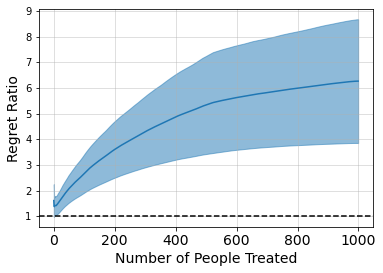

In [421]:
### e-greedy vs. optimism Regret Plots for Reward Maximization ###
### Comparison Plot for Convergence ###
fig, ax = plt.subplots()
color_patches = []

results = results_rew_max + results_rew_max_2 
results_e_greedy = results_e_greedy_rew_max + results_e_greedy_rew_max_2 

oracle_pihat_utility_vals = np.array([result[0][1] for result in results])
oracle_e_greedy_utility_vals = np.array([result[0][1] for result in results_e_greedy])
oracle_pistar_utility_vals = np.array([result[0][2] for result in results_e_greedy])

cum_pistar_util = np.cumsum(oracle_pistar_utility_vals, axis=1)
cum_pihat_util = np.cumsum(oracle_pihat_utility_vals, axis=1)
cum_e_greedy_util = np.cumsum(oracle_e_greedy_utility_vals, axis=1)

regret_pihat = np.cumsum(np.array([result[0][2] for result in results]) - 
                         np.array([result[0][1] for result in results]), axis=1)
regret_e_greedy = np.cumsum(np.array([result[0][2] for result in results_e_greedy]) - 
                            np.array([result[0][1] for result in results_e_greedy]), axis=1)
mean_regret_pihat = np.mean(regret_pihat, axis=1)

regret_ratio = regret_e_greedy / regret_pihat

mean_regret_ratio = np.mean(regret_ratio, axis=0)
ste_regret_ratio = stats.sem(regret_ratio, axis=0)

color = colors[0]
plt.plot(np.mean(regret_ratio, axis=0), color = color)
h1 = plt.fill_between(np.arange(mean_regret_ratio.shape[0]), 
                     mean_regret_ratio-2*ste_regret_ratio, 
                     mean_regret_ratio+2*ste_regret_ratio,
                    alpha=0.5,
                        color=color)

plt.axhline(y=1, linestyle="--", c="black")
plt.ylabel("Regret Ratio", fontsize=14)
plt.xlabel("Number of People Treated", fontsize=14)
plt.xticks(fontsize=14)
plt.grid(alpha=0.5)
plt.savefig("scc_regret_ratios.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')